In [ ]:
# Unstructured Data Analytics: Group Assignment #1
# Luxury Car Market Analysis for JD Power and Associates

# Team Members
# Names: Tarun Chandrasekaran

# This notebook contains the analysis of social media conversations about entry-level luxury cars in the USA.

## IMPORT STATEMENTS

In [3]:
# imports
# Install required libraries
!pip install requests beautifulsoup4 pandas

import requests
from bs4 import BeautifulSoup
import csv
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import MDS
import pandas as pd
import time
from datetime import datetime
from google.colab import files
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import itertools

#ntlk data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## SCRAPER

In [4]:
# Install necessary packages
!apt-get update
!apt-get install -y firefox-esr
!pip install selenium pandas

from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import time

# Setup Firefox options
firefox_options = Options()
firefox_options.add_argument("--headless")

# Initialize the WebDriver
driver = webdriver.Firefox(options=firefox_options)

# Initialize DataFrame to store comments
comments = pd.DataFrame(columns=['Date', 'user_id', 'comments'])

page = 1
max_retries = 3

while True:
    print(f"Scraping page {page}. Current number of comments: {len(comments)}")

    if len(comments.index) >= 20000:  # Increased to 20000
        break

    url = f"https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{page}"

    retries = 0
    while retries < max_retries:
        try:
            driver.get(url)
            # Wait for the comments to load
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//*[contains(@id,'Comment_')]")))
            break
        except TimeoutException:
            print(f"Timeout on page {page}. Retrying...")
            retries += 1
            if retries == max_retries:
                print(f"Failed to load page {page} after {max_retries} attempts. Moving to next page.")
                page += 1
                continue

    ids = driver.find_elements(By.XPATH, "//*[contains(@id,'Comment_')]")
    comment_ids = [i.get_attribute('id') for i in ids]

    for x in comment_ids:
        try:
            # Extract date
            user_date = driver.find_element(By.XPATH, f'//*[@id="{x}"]/div/div[2]/div[2]/span[1]/a/time')
            date = user_date.get_attribute('title')

            # Extract user id
            userid_element = driver.find_element(By.XPATH, f'//*[@id="{x}"]/div/div[2]/div[1]/span[1]/a[2]')
            userid = userid_element.text

            # Extract comment
            user_message = driver.find_element(By.XPATH, f'//*[@id="{x}"]/div/div[3]/div/div[1]')
            comment = user_message.text

            # Add to DataFrame
            comments.loc[len(comments)] = [date, userid, comment]
        except NoSuchElementException:
            print(f"Failed to extract data for comment {x} on page {page}. Skipping.")

    page += 1
    time.sleep(2)  # Be polite to the server

# Close the browser
driver.quit()

# Save to CSV
comments.to_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/edmunds_comments.csv", index=False)
print(f"Scraped {len(comments)} comments and saved to edmunds_comments.csv")

# Display the first few rows and basic statistics
print(comments.head())
print(comments.describe())

# Optional: Display word count statistics
comments['word_count'] = comments['comments'].apply(lambda x: len(str(x).split()))
print("\nWord count statistics:")
print(comments['word_count'].describe())

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,595 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,585 kB]
Get:14 http://a

## SCRAPER FOR CAR BRANDS & MODELS

In [ ]:
import requests
from bs4 import BeautifulSoup
import os
import time
import re

def scrape_kbb(max_retries=3):
    url = "https://www.kbb.com/car-make-model-list/new/view-all/model/"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()

            soup = BeautifulSoup(response.text, 'html.parser')

            results = set()  # Use a set to avoid duplicates
            rows = soup.find_all('div', class_=re.compile(r'css-.*36$'))

            print(f"Number of rows found: {len(rows)}")

            for i in range(0, len(rows), 3):  # Process rows in groups of 3
                if i + 2 < len(rows):
                    model = rows[i].text.strip()
                    make = rows[i+1].text.strip()

                    # Convert to lowercase and add to results
                    results.add(f"{make.lower()},{model.lower()}")

            # Sort results alphabetically by brand name
            sorted_results = sorted(results)

            print(f"Total unique make-model pairs found: {len(sorted_results)}")
            return sorted_results

        except requests.RequestException as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt == max_retries - 1:
                raise

        time.sleep(5)  # Wait for 5 seconds before retrying

    raise Exception("Failed to scrape after multiple attempts")

try:
    results = scrape_kbb()

    directory = "/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/"
    os.makedirs(directory, exist_ok=True)

    file_path = os.path.join(directory, "car_brands_models.txt")
    with open(file_path, "w") as f:
        for result in results:
            f.write(f"{result}\n")

    print(f"Scraping completed. Results saved to '{file_path}'.")
    print(f"Number of entries written to file: {len(results)}")

except Exception as e:
    print(f"Scraping failed: {str(e)}")
    print("Please check the website manually to see if its structure has changed or if there are any access restrictions.")

Number of rows found: 1710
Total unique make-model pairs found: 570
Scraping completed. Results saved to '/content/drive/MyDrive/Colab Notebooks/UDA 1/car_brands_models.txt'.
Number of entries written to file: 570


# TASK A:
#### TESTING ZIPF'S LAW

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from scipy import stats

# Load the data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/edmunds_comments.csv")

# Combine all comments into a single string
all_text = " ".join(df['comments'].astype(str))

# Tokenize the text (convert to lowercase and split into words)
words = re.findall(r'\w+', all_text.lower())

# Count word frequencies
word_counts = Counter(words)

# Get the top 1000 words
top_words = word_counts.most_common(1000)

# Prepare data for plotting
ranks = range(1, len(top_words) + 1)
frequencies = [count for word, count in top_words]

# Plot log-log graph
plt.figure(figsize=(12, 8))
plt.loglog(ranks, frequencies, 'b.')
plt.title("Zipf's Law: Word Frequency vs Rank (Log-Log Scale)")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/final_zipf_law_plot.png')
plt.close()

# Econometric test
log_ranks = np.log(ranks)
log_frequencies = np.log(frequencies)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(log_ranks, log_frequencies)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

# Plot the most common 100 words against the theoretical prediction
plt.figure(figsize=(12, 8))
plt.loglog(ranks[:100], frequencies[:100], 'b.', label='Observed')
theoretical = [np.exp(intercept) * r**slope for r in ranks[:100]]
plt.loglog(ranks[:100], theoretical, 'r-', label='Theoretical (Fitted)')
plt.title("Zipf's Law: Top 100 Words - Observed vs Theoretical")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/final_zipf_law_top100_plot.png')
plt.close()

print("Plots saved as 'zipf_law_plot.png' and 'zipf_law_top100_plot.png'")

Slope: -1.030894169287541
Intercept: 12.67143617429165
R-squared: 0.9930562846488915
P-value: 0.0
Plots saved as 'zipf_law_plot.png' and 'zipf_law_top100_plot.png'


# TASK B:
#### TOP 10 BRANDS FROM FREQUENCY COUNT

In [6]:
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Load the Edmunds forum data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/edmunds_comments.csv")

# Load the brand-model data
brand_model_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/brandmodel.txt")

# Create a dictionary to map models to brands
model_to_brand = {}
for _, row in brand_model_df.iterrows():
    brand = row['brand'].lower()
    models = row['model'].lower().split(',')
    for model in models:
        model_to_brand[model.strip()] = brand

# Create a set of all brands and models for quick lookup
all_brand_models = set(model_to_brand.keys()) | set(model_to_brand.values())

def process_comment(comment):
    # Check if comment is a string, if not, convert to string or return empty list
    if not isinstance(comment, str):
        if pd.isna(comment):
            return []
        comment = str(comment)

    # Tokenize the comment
    words = re.findall(r'\b\w+\b', comment.lower())

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Replace models with brands and count unique brands
    brands = set()
    for word in words:
        if word in all_brand_models:
            brand = model_to_brand.get(word, word)
            brands.add(brand)

    return list(brands)

# Process all comments
brand_counts = Counter()
for comment in df['comments']:
    unique_brands_in_comment = set(process_comment(comment))
    brand_counts.update(unique_brands_in_comment)

# Get the top 10 brands
top_10_brands = brand_counts.most_common(10)

# Print the results
print("Top 10 brands and their frequencies:")
for brand, count in top_10_brands:
    print(f"{brand}: {count}")

# Optional: Save results to a CSV file
results_df = pd.DataFrame(top_10_brands, columns=['Brand', 'Frequency'])
results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/top_10_brands.csv', index=False)
print("\nResults saved to 'top_10_brands.csv'")

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar([brand for brand, _ in top_10_brands], [count for _, count in top_10_brands])
plt.title("Top 10 Car Brands Mentioned in Edmunds Forum")
plt.xlabel("Brand")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/top_10_brands_plot.png')
plt.close()
print("Plot saved as 'top_10_brands_plot.png'")

Top 10 brands and their frequencies:
bmw: 5501
audi: 2973
acura: 2072
lexus: 1917
infiniti: 1466
honda: 1399
nissan: 888
toyota: 846
porsche: 738
cadillac: 719

Results saved to 'top_10_brands.csv'
Plot saved as 'top_10_brands_plot.png'


# TASK C:
#### LIFT CALCULATIONS

Lift Ratios:
honda - toyota: 2.51
nissan - toyota: 1.91
honda - nissan: 1.06
infiniti - nissan: 0.94
lexus - infiniti: 0.89
lexus - toyota: 0.86
acura - infiniti: 0.79
acura - honda: 0.79
infiniti - cadillac: 0.53
acura - lexus: 0.52
lexus - cadillac: 0.48
audi - porsche: 0.47
bmw - audi: 0.44
audi - cadillac: 0.39
audi - infiniti: 0.33
audi - acura: 0.31
bmw - cadillac: 0.29
acura - cadillac: 0.28
toyota - porsche: 0.28
bmw - lexus: 0.28
bmw - porsche: 0.27
audi - lexus: 0.25
bmw - infiniti: 0.25
honda - porsche: 0.23
acura - nissan: 0.18
acura - toyota: 0.16
bmw - acura: 0.15
infiniti - porsche: 0.14
lexus - honda: 0.14
toyota - cadillac: 0.13
porsche - cadillac: 0.13
audi - honda: 0.12
infiniti - honda: 0.12
nissan - porsche: 0.12
lexus - porsche: 0.11
infiniti - toyota: 0.11
acura - porsche: 0.10
bmw - honda: 0.09
audi - toyota: 0.09
bmw - toyota: 0.08
lexus - nissan: 0.08
honda - cadillac: 0.08
bmw - nissan: 0.08
nissan - cadillac: 0.05
audi - nissan: 0.05

Lift ratios saved to 'f

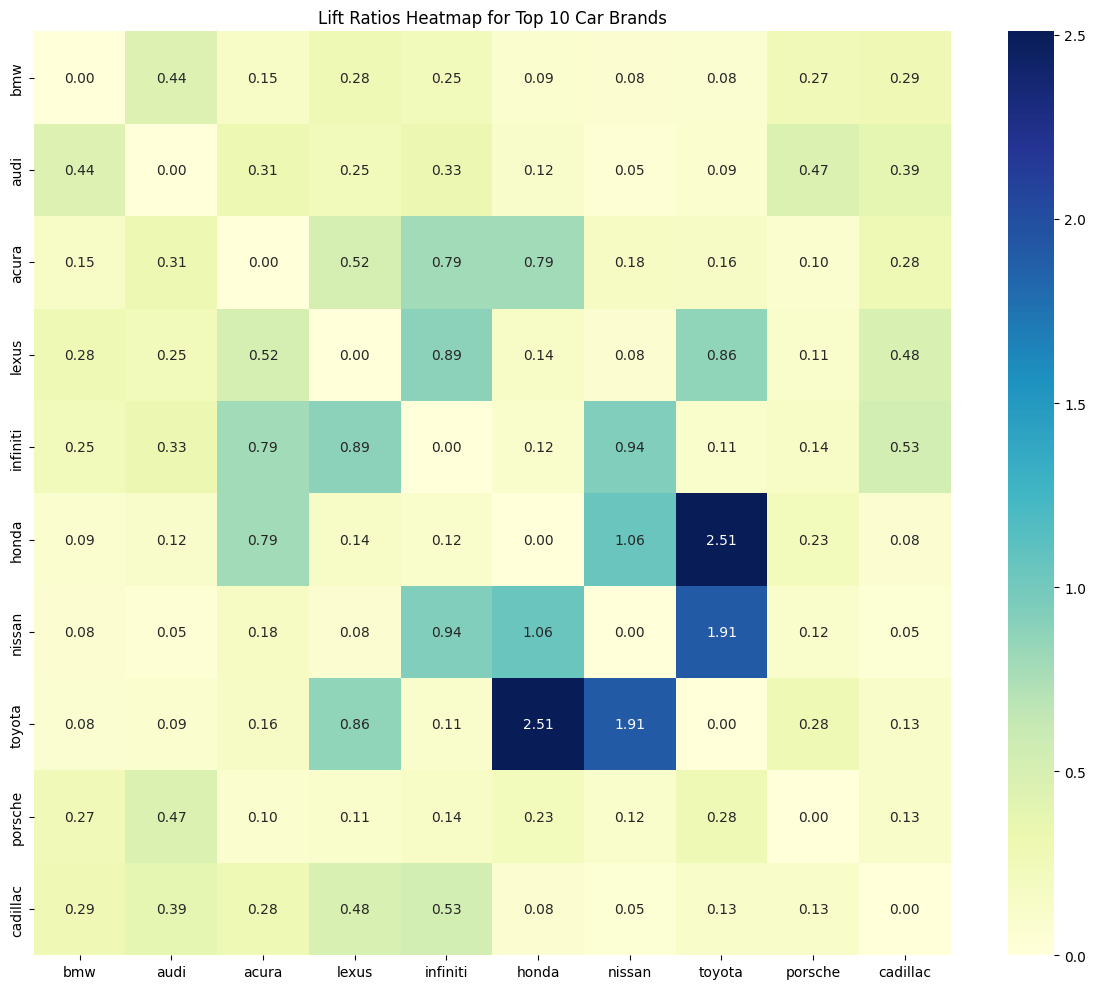

Lift ratios heatmap saved as 'final_lift_ratios_heatmap.png'


In [7]:
!pip install seaborn

import pandas as pd
import numpy as np
from collections import Counter
import re
import itertools

# Load the Edmunds forum data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/edmunds_comments.csv")

# Load the brand-model data
brand_model_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/brandmodel.txt")

# Create a set of all brands for quick lookup
all_brands = set(brand_model_df['brand'].str.lower())

# Top 10 brands from the previous analysis
top_10_brands = ['bmw', 'audi', 'acura', 'lexus', 'infiniti', 'honda', 'nissan', 'toyota', 'porsche', 'cadillac']

def get_brand_mentions(comment, max_distance=10):
    if not isinstance(comment, str):
        return []
    words = re.findall(r'\b\w+\b', comment.lower())
    brand_mentions = []
    for i, word in enumerate(words):
        if word in top_10_brands:
            brand_mentions.append((word, i))
    return brand_mentions

# Initialize counters
brand_counts = {brand: 0 for brand in top_10_brands}
pair_counts = {(brand1, brand2): 0 for brand1, brand2 in itertools.combinations(top_10_brands, 2)}
total_comments = 0

# Process comments
for comment in df['comments']:
    mentions = get_brand_mentions(comment)
    if mentions:
        total_comments += 1
        mentioned_brands = set()
        for i, (brand1, pos1) in enumerate(mentions):
            if brand1 not in mentioned_brands:
                brand_counts[brand1] += 1
                mentioned_brands.add(brand1)
            for brand2, pos2 in mentions[i+1:]:
                if brand2 not in mentioned_brands and abs(pos2 - pos1) <= 10:
                    if (brand1, brand2) in pair_counts:
                        pair_counts[(brand1, brand2)] += 1
                    else:
                        pair_counts[(brand2, brand1)] += 1
                    break

# Calculate lift ratios
lift_ratios = {}
for (brand1, brand2), count in pair_counts.items():
    p_brand1 = brand_counts[brand1] / total_comments
    p_brand2 = brand_counts[brand2] / total_comments
    p_both = count / total_comments

    # Avoid division by zero
    if p_brand1 > 0 and p_brand2 > 0:
        lift = p_both / (p_brand1 * p_brand2)
        lift_ratios[(brand1, brand2)] = lift
    else:
        lift_ratios[(brand1, brand2)] = 0  # Set to 0 instead of using 'N/A'

# Print results
print("Lift Ratios:")
for (brand1, brand2), lift in sorted(lift_ratios.items(), key=lambda x: x[1], reverse=True):
    print(f"{brand1} - {brand2}: {lift:.2f}")

# Save results to CSV
results = []
for (brand1, brand2), lift in lift_ratios.items():
    results.append({'Brand 1': brand1, 'Brand 2': brand2, 'Lift Ratio': lift})
results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/final_lift_ratios.csv', index=False)
print("\nLift ratios saved to 'final_lift_ratios.csv'")

# Create a heatmap of lift ratios
import seaborn as sns
import matplotlib.pyplot as plt

lift_matrix = np.zeros((10, 10))
for i, brand1 in enumerate(top_10_brands):
    for j, brand2 in enumerate(top_10_brands):
        if i != j:
            lift = lift_ratios.get((brand1, brand2), 0) or lift_ratios.get((brand2, brand1), 0)
            lift_matrix[i, j] = lift

plt.figure(figsize=(12, 10))
sns.heatmap(lift_matrix, annot=True, fmt=".2f", xticklabels=top_10_brands, yticklabels=top_10_brands, cmap="YlGnBu")
plt.title("Lift Ratios Heatmap for Top 10 Car Brands")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/final_lift_ratios_heatmap.png')
plt.show()

print("Lift ratios heatmap saved as 'final_lift_ratios_heatmap.png'")

# TASK D:
#### MDS

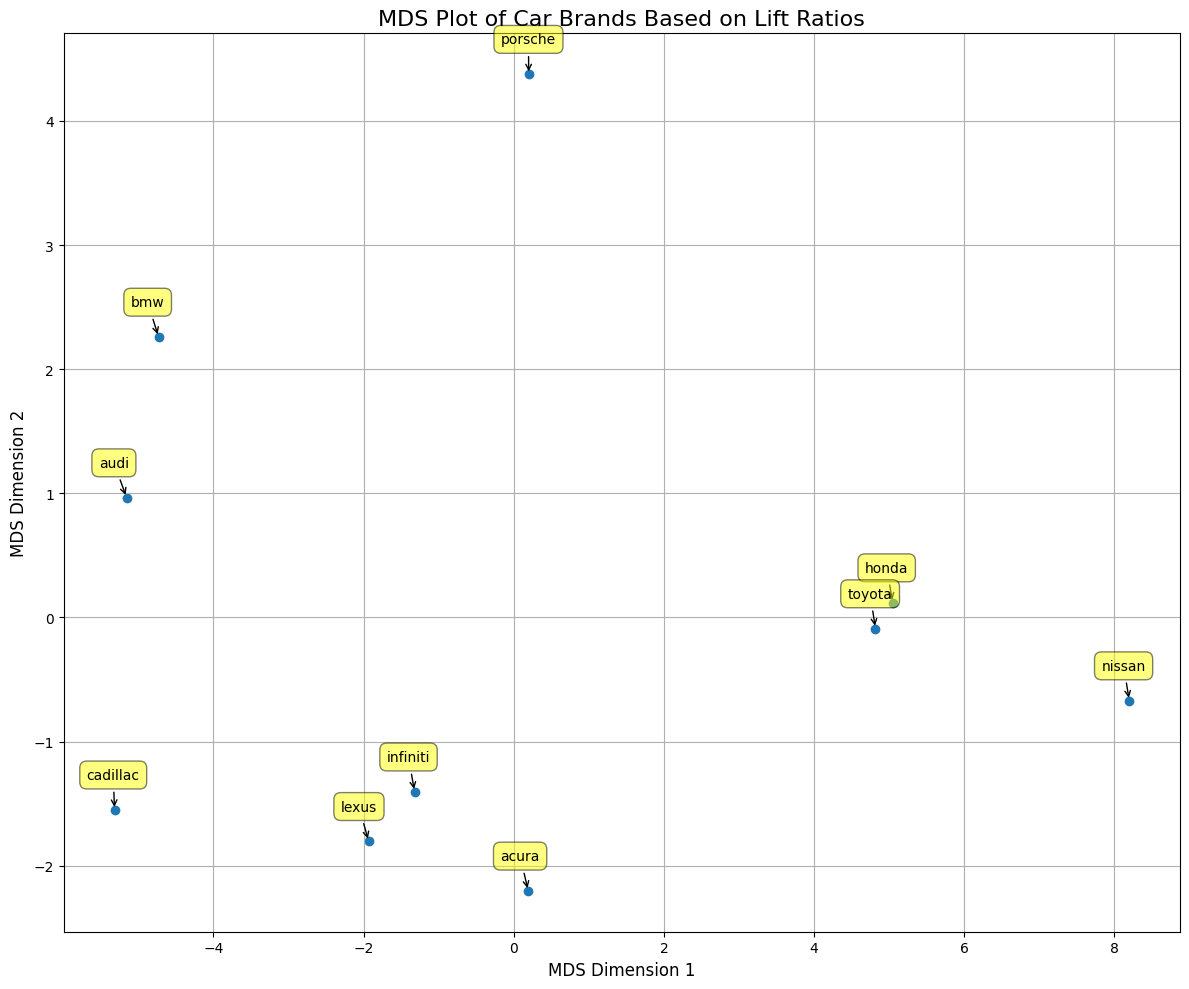

Improved MDS map saved as 'mds_top10_brands.png'

MDS Coordinates:
bmw: [-4.73044355  2.25928862]
audi: [-5.15592037  0.9653582 ]
acura: [ 0.19295648 -2.20299537]
lexus: [-1.93254275 -1.80369338]
infiniti: [-1.32096534 -1.40443859]
honda: [5.04808859 0.11945849]
nissan: [ 8.19858893 -0.67010462]
toyota: [ 4.8180379  -0.08973619]
porsche: [0.19930895 4.37657151]
cadillac: [-5.31710884 -1.54970867]


In [10]:
import pandas as pd
import numpy as np
from sklearn import manifold
import matplotlib.pyplot as plt

# Load the lift ratios
lift_ratios_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/final_lift_ratios.csv')

# Top 10 brands
top_10_brands = ['bmw', 'audi', 'acura', 'lexus', 'infiniti', 'honda', 'nissan', 'toyota', 'porsche', 'cadillac']

# Create a lift matrix
lift_matrix = pd.DataFrame(index=top_10_brands, columns=top_10_brands)
for _, row in lift_ratios_df.iterrows():
    brand1, brand2, lift = row['Brand 1'], row['Brand 2'], row['Lift Ratio']
    if brand1 in top_10_brands and brand2 in top_10_brands:
        lift_matrix.loc[brand1, brand2] = lift_matrix.loc[brand2, brand1] = lift

# Fill diagonal with 1 and NaN with 0
np.fill_diagonal(lift_matrix.values, 1)
lift_matrix = lift_matrix.fillna(0)

# Create dissimilarity matrix
dissimilarity_matrix = 1 / (lift_matrix + 1e-10)
np.fill_diagonal(dissimilarity_matrix.values, 0)  # Set diagonal to zero

# Multidimensional Scaling (MDS)
seed = np.random.RandomState(seed=42)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   random_state=seed, dissimilarity="precomputed", n_jobs=-1)

try:
    results = mds.fit(dissimilarity_matrix)
    coords = results.embedding_
except ValueError as e:
    print(f"Error during MDS fitting: {e}")
    coords = np.zeros((len(lift_matrix), 2))  # Placeholder in case of error

# Plotting the MDS results
plt.figure(figsize=(12, 10))
plt.scatter(coords[:, 0], coords[:, 1], marker='o')

# Annotate each point with the corresponding brand name
for label, x, y in zip(lift_matrix.index, coords[:, 0], coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title('MDS Plot of Car Brands Based on Lift Ratios', fontsize=16)
plt.xlabel('MDS Dimension 1', fontsize=12)
plt.ylabel('MDS Dimension 2', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/mds_top10_brands.png', dpi=300, bbox_inches='tight')
plt.show()

print("Improved MDS map saved as 'mds_top10_brands.png'")

# Print coordinates for reference
print("\nMDS Coordinates:")
for brand, coord in zip(top_10_brands, coords):
    print(f"{brand}: {coord}")

# TASK E:
#### ADVICE ON C&D

1. Brand Clustering and Positioning:
   - The MDS map shows distinct clustering of brands, which suggests different market positioning and consumer perceptions.
   - BMW and Audi are closely positioned, indicating they are perceived similarly and likely compete directly in the luxury market.
   - Honda, Toyota, and Nissan form another cluster, suggesting they are viewed more as mainstream brands even in luxury discussions.
   - Acura, Lexus, and Infiniti form a middle ground between the German luxury brands and their Japanese parent companies.

2. Brand Associations:
   - Honda and Toyota have the strongest association (lift ratio of 2.51), indicating that these brands are often discussed together, possibly as benchmarks or alternatives in the entry-level luxury segment.
   - Nissan and Toyota also have a strong association (1.91), reinforcing the Japanese brand cluster.
   - Infiniti shows moderate associations with both Nissan (0.94) and Lexus (0.89), positioning it as a bridge between mainstream and luxury Japanese brands.

3. Luxury Brand Dynamics:
   - BMW and Audi have a moderate association (0.44), confirming their position as direct competitors in the luxury market.
   - Porsche appears to be somewhat isolated in the MDS map, suggesting it might be perceived as a more exclusive or performance-oriented brand compared to the other luxury marques.

4. Entry-Level Luxury Positioning:
   - Acura, Infiniti, and Lexus show moderate associations with each other and with their parent companies (Honda, Nissan, and Toyota respectively). This suggests that while they are perceived as luxury brands, they still carry some association with their mainstream counterparts.

5. Cross-Segment Comparisons:
   - The lower lift ratios between German luxury brands (BMW, Audi) and Japanese mainstream brands (Honda, Toyota, Nissan) indicate that these are not frequently compared directly, suggesting different target markets.

6. Cadillac's Position:
   - Cadillac shows relatively low associations with other brands, and its position in the MDS map is somewhat isolated. This might indicate a unique market position or possibly a lack of strong consumer engagement in the discussions analyzed.

Business Implications and Recommendations:

1. For BMW and Audi: Focus on differentiation strategies to stand out from each other, as they are closely associated in consumer discussions.

2. For Acura, Infiniti, and Lexus: Leverage their associations with respected mainstream brands while emphasizing their luxury features to justify their premium positioning.

3. For Honda, Toyota, and Nissan: There may be opportunities to more strongly position their luxury sub-brands (Acura, Lexus, Infiniti) as distinct entities in the luxury market.

4. For Porsche: Its unique position could be leveraged for premium pricing and exclusive marketing strategies in the entry-level luxury segment.

5. For Cadillac: Consider strategies to increase engagement and strengthen associations with other luxury brands to improve its position in the entry-level luxury car discussions.

6. Overall Market Strategy: Brands should be aware of which other brands they are most closely associated with in consumer discussions, as these likely represent their closest competitors or complementary brands in the minds of consumers.


# TASK F:
#### TOP 5 FEATURES

In [15]:
import pandas as pd
from collections import Counter
import re
import itertools

# Load the Edmunds forum data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/edmunds_comments.csv")

# Load the brand-model data
brand_model_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/brandmodel.txt")

# Create a dictionary to map models to brands
model_to_brand = {}
for _, row in brand_model_df.iterrows():
    brand = row['brand'].lower()
    models = row['model'].lower().split(',')
    for model in models:
        model_to_brand[model.strip()] = brand

# Top 5 brands
top_10_brands = ['bmw', 'audi', 'acura', 'lexus', 'infiniti', 'honda', 'nissan', 'toyota', 'porsche', 'cadillac']

# List of attributes to look for
attributes = [
    'performance', 'luxury', 'price', 'interior', 'power',
    'comfort', 'reliability', 'technology', 'safety', 'efficiency',
    'handling', 'acceleration', 'braking', 'design', 'style',
    'quality', 'spaciousness', 'fuel_economy', 'infotainment',
    'navigation', 'sound_system', 'connectivity', 'bluetooth',
    'leather', 'wood_trim', 'carbon_fiber', 'suspension',
    'ride_quality', 'noise_insulation', 'mpg', 'horsepower',
    'torque', 'transmission', 'awd', 'rwd', 'drivetrain',
    'engine', 'turbo', 'hybrid', 'electric', 'exhaust',
    'wheels', 'tires', 'brakes', 'steering', 'visibility',
    'blindspot', 'parking_assist', 'cruise_control', 'adaptive_cruise',
    'lane_assist', 'collision_warning', 'airbags', 'warranty',
    'maintenance', 'resale_value', 'depreciation', 'dealership',
    'customer_service', 'repairs', 'reliability', 'durability',
    'build_quality', 'craftsmanship', 'ergonomics', 'seat_comfort',
    'legroom', 'headroom', 'cargo_space', 'trunk_space',
    'folding_seats', 'sunroof', 'panoramic_roof', 'led_lights',
    'headlights', 'fog_lights', 'tail_lights', 'climate_control',
    'air_conditioning', 'heating', 'ventilated_seats', 'heated_seats',
    'steering_wheel', 'paddle_shifters', 'dashboard', 'instrument_cluster',
    'head_up_display', 'touchscreen', 'voice_control', 'smartphone_integration',
    'apple_carplay', 'android_auto', 'usb_ports', 'wireless_charging',
    'keyless_entry', 'push_button_start', 'remote_start', 'driver_assist',
    'autopilot', 'self_parking', 'backup_camera', '360_camera',
    'night_vision', 'off_road', 'towing', 'roof_rack',
    'color_options', 'customization', 'special_editions', 'sport_package',
    'premium_package', 'trim_levels', 'base_model', 'top_trim'
]

def find_co_occurrences(message, brands, attributes):
    words = message.lower().split()
    found_brands = []
    found_attributes = []

    for word in words:
        if word in brands:
            found_brands.append(word)
        if word in attributes:
            found_attributes.append(word)

    co_occurrences = set()
    for brand in found_brands:
        for attribute in found_attributes:
            co_occurrences.add((brand, attribute))

    return co_occurrences

brand_counter = Counter()
attribute_counter = Counter()
co_occurrence_counter = Counter()

total_messages = len(df)

# Process all comments
for comment in df['comments']:
    if not isinstance(comment, str):
        continue

    # Replace models with brands
    for model, brand in model_to_brand.items():
        comment = comment.lower().replace(model, brand)

    # Count brands and attributes
    words = comment.split()
    brands_in_comment = set(word for word in words if word in top_10_brands)
    attributes_in_comment = set(word for word in words if word in attributes)

    brand_counter.update(brands_in_comment)
    attribute_counter.update(attributes_in_comment)

    # Find co-occurrences
    co_occurrences = find_co_occurrences(comment, top_10_brands, attributes)
    co_occurrence_counter.update(co_occurrences)

def calculate_lift(brand, attribute, brand_counter, attribute_counter, co_occurrence_counter, total_messages):
    P_A = brand_counter[brand] / total_messages
    P_B = attribute_counter[attribute] / total_messages
    P_AB = co_occurrence_counter[(brand, attribute)] / total_messages

    if P_A * P_B == 0:
        return 0
    return P_AB / (P_A * P_B)

# Calculate lift ratios
lift_results = []
for brand in top_10_brands:
    for attribute in attributes:
        lift = calculate_lift(brand, attribute, brand_counter, attribute_counter, co_occurrence_counter, total_messages)
        lift_results.append((brand, attribute, lift))

# Create a DataFrame with brands as rows and attributes as columns
lift_df = pd.DataFrame(lift_results, columns=['Brand', 'Attribute', 'Lift'])

# Aggregate lift values in case of duplicates (using mean, but you could use max, min, etc.)
lift_df_aggregated = lift_df.groupby(['Brand', 'Attribute'])['Lift'].mean().reset_index()

# Now pivot the aggregated dataframe
final_lift_matrix = lift_df_aggregated.pivot(index='Brand', columns='Attribute', values='Lift')

# Fill any NaN values with 0
final_lift_matrix.fillna(0, inplace=True)

# Print results
print("Top 5 most frequently mentioned attributes:")
print(attribute_counter.most_common(5))

print("\nTop 5 lift ratios for each brand:")
for brand in top_10_brands:
    print(f"\n{brand.capitalize()}:")
    top_attributes = final_lift_matrix.loc[brand].nlargest(5)
    for attribute, lift in top_attributes.items():
        print(f"  {attribute}: {lift:.2f}")

print("\nStrongest brand-attribute associations:")
for brand in top_10_brands:
    max_attribute = final_lift_matrix.loc[brand].idxmax()
    max_lift = final_lift_matrix.loc[brand].max()
    print(f"{brand.capitalize()} is most strongly associated with {max_attribute} (lift: {max_lift:.2f})")

# Save results
final_lift_matrix.to_csv('/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/brand_attribute_lift_ratios.csv', index=True)
print("\nLift ratios saved to 'brand_attribute_lift_ratios.csv'")

Top 5 most frequently mentioned attributes:
[('price', 1708), ('performance', 1625), ('engine', 1217), ('power', 969), ('awd', 875)]

Top 5 lift ratios for each brand:

Bmw:
  connectivity: 2.51
  ergonomics: 2.19
  headlights: 2.09
  maintenance: 1.95
  turbo: 1.93

Audi:
  connectivity: 4.28
  headroom: 3.89
  dashboard: 3.67
  durability: 3.65
  ergonomics: 3.11

Acura:
  durability: 3.07
  legroom: 2.78
  headroom: 2.69
  awd: 2.62
  electric: 2.50

Lexus:
  connectivity: 1.65
  craftsmanship: 1.65
  heating: 1.65
  touchscreen: 1.65
  towing: 1.65

Infiniti:
  durability: 5.48
  touchscreen: 4.63
  navigation: 4.05
  efficiency: 3.29
  technology: 3.01

Honda:
  craftsmanship: 18.67
  electric: 4.77
  towing: 3.11
  horsepower: 2.95
  hybrid: 2.57

Nissan:
  touchscreen: 11.42
  towing: 7.61
  heating: 5.07
  exhaust: 4.47
  durability: 3.38

Toyota:
  towing: 5.52
  hybrid: 4.97
  connectivity: 4.14
  depreciation: 3.83
  dealership: 2.94

Porsche:
  craftsmanship: 17.95
  dashbo

# TASK G:
#### ADVICE ON F

1. Focus on Key Attributes:
   The top 5 most frequently mentioned attributes (price, performance, engine, power, and AWD) indicate what consumers are most interested in. Advise your client to ensure their marketing and product development strategies address these key areas.

2. Brand-Specific Strategies:

   a) BMW:
   - Leverage its strong association with connectivity (lift: 2.51).
   - Emphasize ergonomics and headlight technology in marketing.
   - Highlight maintenance programs to address consumer interest.

   b) Audi:
   - Strongly promote connectivity features (lift: 4.28).
   - Market spaciousness (headroom) and interior design (dashboard).
   - Emphasize durability to differentiate from competitors.

   c) Acura:
   - Focus on durability as a key selling point (lift: 3.07).
   - Highlight spaciousness (legroom and headroom) in marketing.
   - Promote AWD capabilities and electric/hybrid options.

   d) Lexus:
   - Improve and market connectivity features more aggressively.
   - Emphasize craftsmanship in marketing campaigns.
   - Highlight comfort features like heating and touchscreen interfaces.

   e) Infiniti:
   - Strongly promote durability (lift: 5.48) as a key differentiator.
   - Invest in and market advanced touchscreen and navigation systems.
   - Emphasize efficiency and technology in marketing materials.

   f) Honda:
   - Leverage the strong association with craftsmanship (lift: 18.67) to boost luxury perception.
   - Promote electric and hybrid options.
   - Highlight towing capabilities and horsepower to appeal to performance-minded consumers.

   g) Nissan:
   - Focus on advanced touchscreen interfaces (lift: 11.42).
   - Promote towing capabilities and heating features.
   - Address durability in marketing to compete with luxury brands.

   h) Toyota:
   - Emphasize towing capabilities (lift: 5.52) and hybrid technology.
   - Improve and market connectivity features.
   - Highlight value retention (low depreciation) and dealership experience.

   i) Porsche:
   - Leverage the strong association with craftsmanship (lift: 17.95).
   - Promote dashboard design and efficiency.
   - Continue to emphasize performance (horsepower and acceleration).

   j) Cadillac:
   - Address depreciation concerns (lift: 4.21) through warranty programs or value propositions.
   - Emphasize quality improvements in marketing.
   - Improve dealership experience and highlight Bluetooth connectivity.

3. Cross-Brand Competitive Strategies:
   - Connectivity is a key battleground, especially for BMW, Audi, and Lexus. Advise investing in this area.
   - Durability is a strong point for Infiniti and Acura. Other brands should consider how to compete on this attribute.
   - Craftsmanship is a major strength for Honda and Porsche. Luxury brands should consider how to enhance this perception.

4. Market Positioning:
   - Entry-level luxury brands (e.g., Acura, Infiniti) should focus on durability and technology to compete with higher-end luxury brands.
   - Traditional luxury brands (e.g., BMW, Audi) should emphasize connectivity and ergonomics to maintain their premium position.
   - Mainstream brands with luxury aspirations (e.g., Honda, Toyota) should leverage their perceived strengths in craftsmanship and hybrid technology.

5. Innovation Focus:
   - Advise investing in connectivity features across all brands.
   - Recommend developing and marketing advanced touchscreen interfaces, especially for Nissan and Infiniti.
   - Suggest focusing on electric and hybrid technologies, particularly for Honda and Toyota.

6. Address Weaknesses:
   - Cadillac needs to address depreciation concerns urgently.
   - Lexus should work on improving its perceived connectivity features.
   - BMW and Audi could benefit from improving their perceived durability.

7. Capitalize on Unique Strengths:
   - Honda and Porsche should leverage their strong association with craftsmanship to differentiate in the luxury market.
   - Toyota should promote its towing capabilities to appeal to a specific market segment.
   - Infiniti should emphasize its perceived durability and technology features.


# TASK H:
#### ASPIRATIONAL BRAND

In [13]:
import pandas as pd
import re
from collections import Counter

# Load the Edmunds forum data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/edmunds_comments.csv")

# Load the brand-model data
brand_model_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UDA 1 FINAL/brandmodel.txt")

# Create a set of all brands for quick lookup
all_brands = set(brand_model_df['brand'].str.lower())

# List of aspirational phrases
aspirational_phrases = [
    "want to buy", "dream car", "wish I had", "hope to own", "aspire to own",
    "would love to have", "can't wait to get", "saving up for", "plan to purchase",
    "considering buying", "thinking about getting", "my next car will be"
]

# Function to check if a message contains an aspirational phrase
def contains_aspirational_phrase(message):
    return any(phrase in message.lower() for phrase in aspirational_phrases)

# Function to find brands mentioned in a message
def find_brands(message):
    return [brand for brand in all_brands if brand in message.lower()]

# Initialize counters
total_messages = len(df)
aspirational_messages = 0
brand_mentions = Counter()
aspirational_brand_mentions = Counter()

# Process all messages
for message in df['comments']:
    if not isinstance(message, str):
        continue

    message = message.lower()
    brands = find_brands(message)
    brand_mentions.update(brands)

    if contains_aspirational_phrase(message):
        aspirational_messages += 1
        aspirational_brand_mentions.update(brands)

# Calculate lift ratios
lift_ratios = {}
for brand in all_brands:
    P_brand = brand_mentions[brand] / total_messages
    P_aspirational = aspirational_messages / total_messages
    P_brand_and_aspirational = aspirational_brand_mentions[brand] / total_messages

    if P_brand > 0 and P_aspirational > 0:
        lift = P_brand_and_aspirational / (P_brand * P_aspirational)
        lift_ratios[brand] = lift

# Find the most aspirational brand
most_aspirational_brand = max(lift_ratios, key=lift_ratios.get)
highest_lift = lift_ratios[most_aspirational_brand]

print(f"The most aspirational brand is {most_aspirational_brand} with a lift ratio of {highest_lift:.2f}")

# Print top 5 aspirational brands
print("\nTop 5 Aspirational Brands:")
for brand, lift in sorted(lift_ratios.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{brand}: {lift:.2f}")

# Analysis description
print("\nAnalysis Description:")
print("1. We identified aspirational phrases indicating desire to own or buy a car.")
print("2. We counted messages containing these phrases and brand mentions within them.")
print("3. We calculated lift ratios to measure the association between brands and aspirational phrases.")
print("4. The brand with the highest lift ratio is considered the most aspirational.")

print("\nBusiness Implications:")
print(f"1. {most_aspirational_brand.capitalize()} has a strong aspirational appeal in the luxury car market.")
print("2. This suggests potential for premium pricing and brand-focused marketing strategies.")
print("3. There may be opportunities to convert this aspiration into actual sales through targeted campaigns.")
print("4. The brand could focus on maintaining its aspirational status while also addressing any barriers to purchase.")
print("5. Competitors might need to reassess their brand positioning relative to " + most_aspirational_brand.capitalize() + ".")

The most aspirational brand is mitsubishi with a lift ratio of 5.81

Top 5 Aspirational Brands:
mitsubishi: 5.81
chrysler: 2.62
ford: 2.26
ferrari: 2.12
dodge: 1.89

Analysis Description:
1. We identified aspirational phrases indicating desire to own or buy a car.
2. We counted messages containing these phrases and brand mentions within them.
3. We calculated lift ratios to measure the association between brands and aspirational phrases.
4. The brand with the highest lift ratio is considered the most aspirational.

Business Implications:
1. Mitsubishi has a strong aspirational appeal in the luxury car market.
2. This suggests potential for premium pricing and brand-focused marketing strategies.
3. There may be opportunities to convert this aspiration into actual sales through targeted campaigns.
4. The brand could focus on maintaining its aspirational status while also addressing any barriers to purchase.
5. Competitors might need to reassess their brand positioning relative to Mitsubi